In [1]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression

In [2]:
df = pd.read_csv("./data/GNP.csv")
df["GR_GNP"] = np.log(df['GNP']).diff() * 100
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.iloc[1:]

In [3]:
usrec = DataReader("USREC", 
                   "fred", 
                   start=datetime(1947, 1, 1), 
                   end=datetime(2023, 10, 1))

usrec.index = pd.to_datetime(usrec.index)

In [4]:
df = df.merge(usrec, how = "left", on = "DATE")

In [5]:
df = df.rename(columns = {"USREC" : "crise"})

In [27]:
T = df.shape[0]
sigma0 = df[df["crise"] == 0]["GR_GNP"].std()
sigma1 = df[df["crise"] == 1]["GR_GNP"].std()
q = sigma0 / sigma1
beta0 = df[df["crise"] == 0]["GR_GNP"].mean()
beta1 = df[df["crise"] == 1]["GR_GNP"].mean()
lamda = ((beta1-beta0)**2)/sigma1**2

In [10]:
smoothed_marginal_probabilities

,0,1
2,0.891838,0.108162
3,0.975292,0.024708
4,0.989153,0.010847
5,0.985827,0.014173
6,0.000964,0.999036
...,...,...
302,0.998951,0.001049
303,0.997397,0.002603
304,0.994197,0.005803
305,0.997874,0.002126


In [15]:
zeta_1 = smoothed_marginal_probabilities[0]
zeta_2 = smoothed_marginal_probabilities[1]

In [32]:
d = ((lamda**2)*zeta_2*(1-zeta_2)+q**2+(1-q**2)*zeta_2)**(-1)

In [24]:
zeta_2_shifted = zeta_2.shift(1)

In [18]:
sigma_s = zeta_1.mean() * zeta_2.mean() - 1/T*(((zeta_2 - zeta_2.mean())**2).sum())

In [35]:
num = (zeta_2_shifted-zeta_2.mean())*(zeta_2-zeta_2.mean())
den = (T*d.mean())**(-1)+lamda**2*(zeta_2.mean()*zeta_1.mean()-sigma_s**2)
w = 1/T * (1+lamda**2*(num/den))

In [37]:
w

2           NaN
3      0.003290
4      0.003574
5      0.003609
6      0.000412
         ...   
302    0.003689
303    0.003683
304    0.003666
305    0.003667
306    0.003621
Name: 1, Length: 305, dtype: float64

In [38]:
df["Optimized_GNP"] = df["GR_GNP"]*w

In [43]:
df["Optimized_GNP"] = df["Optimized_GNP"].fillna(0)

                         Markov Switching Model Results                         
Dep. Variable:            Optimized_GNP   No. Observations:                  305
Model:             MarkovAutoregression   Log Likelihood                1251.221
Date:                  Sat, 04 May 2024   AIC                          -2486.443
Time:                          15:50:28   BIC                          -2456.680
Sample:                               0   HQIC                         -2474.538
                                  - 305                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0058      0.000     21.797      0.000       0.005       0.006
sigma2      4.997e-06   4.45e-07    

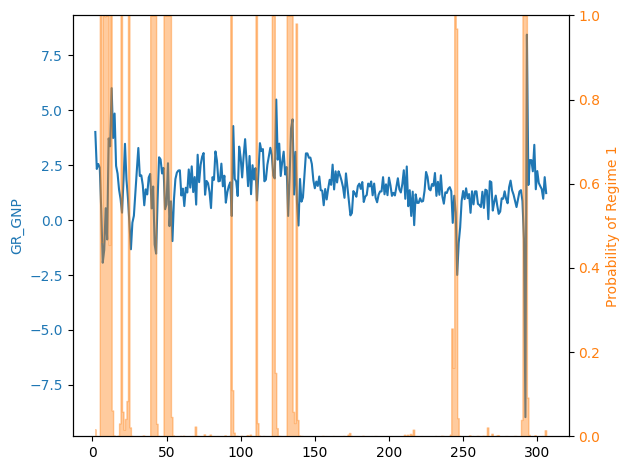

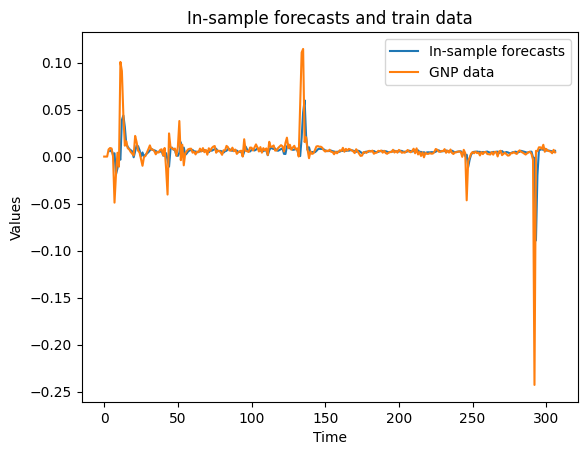

In [44]:
mar_model = MarkovAutoregression(df['Optimized_GNP'], k_regimes=2, order=2, switching_ar=False, switching_variance=True)
mar_res = mar_model.fit()
print(mar_res.summary())
df2 = df.iloc[2:, :]

smoothed_marginal_probabilities = mar_res.smoothed_marginal_probabilities

# Plot the series and the smoothed probabilities
fig, ax1 = plt.subplots()

ax1.plot(df2.index, df2['GR_GNP'], label='GR_GNP')
ax1.set_ylabel('GR_GNP', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx()
ax2.fill_between(df2.index, smoothed_marginal_probabilities[1], step='pre', alpha=0.4, color='C1')
ax2.set_ylabel('Probability of Regime 1', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')
ax2.set_ylim([0, 1])

fig.tight_layout()
plt.show()

in_sample_forecasts = mar_res.predict()

# Plot the data
plt.plot(in_sample_forecasts, label='In-sample forecasts')
plt.plot(df['Optimized_GNP'], label='GNP data')

# Add axis labels and title
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('In-sample forecasts and train data')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [45]:
from sklearn.metrics import mean_squared_error

mean_squared_error(df["Optimized_GNP"].iloc[4:], in_sample_forecasts)

0.00037151889724758866

In [85]:
a = "*********************"

In [86]:
len(a)

21